In [1]:
import os
import time
import warnings
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from numpy import newaxis, concatenate
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from sklearn.metrics import mean_squared_error
from pandas import read_csv, DataFrame,concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential

Using TensorFlow backend.


In [2]:
seq_len = 1
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(),list()
    for i in range(n_in, 0 ,-1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1,i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis =1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace = True)
    return agg

def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()
def predict_sequences_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, window_size-1,predicted[-1], axis=0)
    return predicted

In [4]:
dataset = read_csv('fai1.csv', header = 0, index_col=0)
dataset_stock = read_csv('stock1.csv', header = 0, index_col=0)
values = dataset.values
values_stock = dataset_stock.values
encoder = LabelEncoder()
values[:,0] = encoder.fit_transform(values[:,0])
values_stock[:,0] = encoder.fit_transform(values_stock[:,0])
values = values.astype('float32')
values_stock = values_stock.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled_stock = scaler.fit_transform(values_stock)
reframed = series_to_supervised(scaled, 1, 1)
reframed_stock = series_to_supervised(scaled_stock, 1, 1)
print(reframed.head())
print(reframed_stock.head())

   var1(t-1)   var1(t)
1   0.182609  0.191304
2   0.191304  0.182609
3   0.182609  0.191304
4   0.191304  0.182609
5   0.182609  0.104348
   var1(t-1)   var1(t)
1   0.157798  0.161468
2   0.161468  0.150459
3   0.150459  0.177982
4   0.177982  0.166972
5   0.166972  0.179817


In [5]:
values = reframed.values
values_stock = reframed_stock.values
n_train_hours = 50
n_end = n_train_hours + 5
train = values[:n_train_hours, :]
train_stock = values_stock[:n_train_hours,:]
test = values[n_train_hours:n_end :]
test_stock = values_stock[n_train_hours:n_end:]
train_X, train_y = train[:,:-1], train[:, -1]
train_stock_X, train_stock_y = train_stock[:,:-1], train_stock[:, -1]
test_X, test_y = test[:, :-1], test[:,-1]
test_stock_X, test_stock_y = test_stock[:, :-1], test_stock[:,-1] 
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
train_stock_X = train_stock_X.reshape((train_stock_X.shape[0], 1, train_stock_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
test_stock_X = test_stock_X.reshape((test_stock_X.shape[0],1, test_stock_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
print(train_stock_X.shape, train_stock_y.shape, test_stock_X.shape, test_stock_y.shape)

(50, 1, 1) (50,) (5, 1, 1) (5,)
(50, 1, 1) (50,) (5, 1, 1) (5,)


In [14]:
model = Sequential()
model.add(LSTM(20, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100,return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation("linear"))
start = time.time()
model.add(Dense(1))
model.compile(loss='mse', optimizer='rmsprop')
print("> Compilation Time :", time.time() - start)
history = model.fit(train_X, train_y, epochs=80, batch_size=1, validation_data=(test_X, test_y), verbose=2, shuffle=False)
#print (seq_len)
predicted = predict_sequences_full(model, test_X, seq_len)

> Compilation Time : 0.022899627685546875
Train on 50 samples, validate on 5 samples
Epoch 1/80
0s - loss: 0.0249 - val_loss: 0.0095
Epoch 2/80
0s - loss: 0.0160 - val_loss: 0.0077
Epoch 3/80
0s - loss: 0.0133 - val_loss: 0.0069
Epoch 4/80
0s - loss: 0.0129 - val_loss: 0.0061
Epoch 5/80
0s - loss: 0.0123 - val_loss: 0.0048
Epoch 6/80
0s - loss: 0.0110 - val_loss: 0.0048
Epoch 7/80
0s - loss: 0.0111 - val_loss: 0.0043
Epoch 8/80
0s - loss: 0.0094 - val_loss: 0.0037
Epoch 9/80
0s - loss: 0.0096 - val_loss: 0.0035
Epoch 10/80
0s - loss: 0.0088 - val_loss: 0.0034
Epoch 11/80
0s - loss: 0.0096 - val_loss: 0.0033
Epoch 12/80
0s - loss: 0.0090 - val_loss: 0.0033
Epoch 13/80
0s - loss: 0.0093 - val_loss: 0.0033
Epoch 14/80
0s - loss: 0.0084 - val_loss: 0.0033
Epoch 15/80
0s - loss: 0.0090 - val_loss: 0.0033
Epoch 16/80
0s - loss: 0.0096 - val_loss: 0.0034
Epoch 17/80
0s - loss: 0.0086 - val_loss: 0.0033
Epoch 18/80
0s - loss: 0.0085 - val_loss: 0.0033
Epoch 19/80
0s - loss: 0.0096 - val_loss: 

[0.34319824, 0.31996956, 0.30262536, 0.28980079, 0.28038743]
5


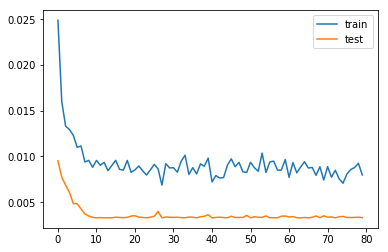

In [15]:
print (predicted)
l = len(predicted)
print (l)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

[ 0.34319824  0.31996956  0.30262536  0.28980079  0.28038743] [ 0.06238532  0.03853211  0.02018349  0.0146789   0.03669725]
MSE: 0.074583


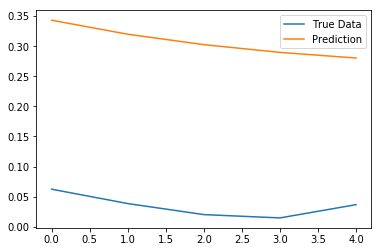

In [17]:
predicted = np.reshape(predicted, (l,))

print(predicted, test_stock_y)

score = mean_squared_error(predicted, test_stock_y)
    
print("MSE: %f" % score)
plot_results(predicted, test_stock_y)